In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, StackingClassifier, BaggingRegressor, \
    GradientBoostingRegressor, StackingRegressor
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor, CatBoostClassifier

# Предобработка данных

In [2]:
dataC = pd.read_csv('red_wine_quality_preprocessed.csv', index_col=0)
dataC.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


<AxesSubplot:>

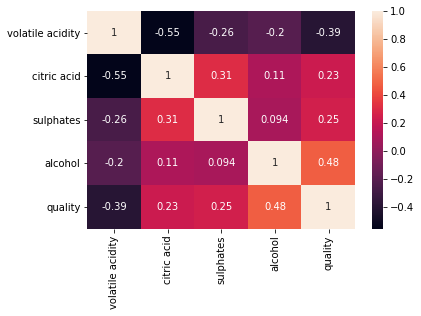

In [3]:
corrmat = dataC.corr()
top_corr_features = corrmat.index[abs(corrmat["quality"]) > 0.2]
dataC = dataC[top_corr_features]
sns.heatmap(dataC.corr(),annot=True)

In [4]:
dataC.isnull().sum()

volatile acidity    0
citric acid         0
sulphates           0
alcohol             0
quality             0
dtype: int64

In [5]:
dataR = pd.read_csv('concrete_compressive_strength_preprocessed.csv', index_col=0)
dataR.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


<AxesSubplot:>

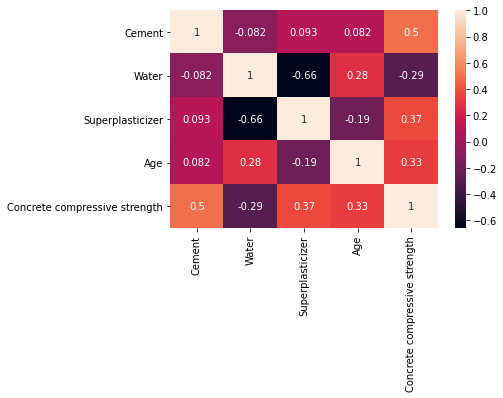

In [6]:
corrmat = dataR.corr()
top_corr_features = corrmat.index[abs(corrmat["Concrete compressive strength"]) > 0.2]
dataR = dataR[top_corr_features]
sns.heatmap(dataR.corr(),annot=True)

In [7]:
dataR.isnull().sum()

Cement                           0
Water                            0
Superplasticizer                 0
Age                              0
Concrete compressive strength    0
dtype: int64

# Классификация

In [8]:
x = dataC.drop(['quality'], axis=1)
y = dataC['quality']
x = StandardScaler().fit(x).transform(x)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

### Base model

In [10]:
params = { 'max_depth': range (1,20, 1)}
dtc = DecisionTreeClassifier()

In [11]:
%%time
dtc_base = GridSearchCV(dtc, params).fit(X_train, y_train)
print(dtc_base.best_params_)
max_depth_best_parameter = dtc_base.best_params_['max_depth']

{'max_depth': 9}
Wall time: 212 ms


In [12]:
y_pred = dtc_base.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.6


### Bagging

In [13]:
params = {'n_estimators': range(10,111,20)}
bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth_best_parameter))

In [14]:
%%time
model = GridSearchCV(bag, params).fit(X_train, y_train)
print(model.best_params_)

{'n_estimators': 90}
Wall time: 3.67 s


In [15]:
y_pred = model.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.653125


### GradientBoosting

In [16]:
%%time
model = GridSearchCV(GradientBoostingClassifier(), params).fit(X_train, y_train)
print(model.best_params_)

{'n_estimators': 70}
Wall time: 10.7 s


In [17]:
y_pred = model.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.59375


### Stacking

In [18]:
%%time
model = StackingClassifier(estimators=[('bag',bag), ('gbc',GradientBoostingClassifier())],final_estimator=dtc_base)
model.fit(X_train, y_train)

Wall time: 4.2 s


StackingClassifier(estimators=[('bag',
                                BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=9))),
                               ('gbc', GradientBoostingClassifier())],
                   final_estimator=GridSearchCV(estimator=DecisionTreeClassifier(),
                                                param_grid={'max_depth': range(1, 20)}))

In [19]:
y_pred = model.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.603125


### Catboost

In [20]:
cat = CatBoostClassifier(iterations=250,logging_level='Silent',allow_writing_files=False)
cat.fit(X_train,y_train)

In [21]:
y_pred = cat.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.65625


# Регрессия

In [22]:
x = dataR.drop(['Concrete compressive strength'], axis=1)
y = dataR['Concrete compressive strength']
x = StandardScaler().fit(x).transform(x)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

### Base model

In [24]:
params = { 'max_depth': range (1,20, 1)}
dtr = DecisionTreeRegressor()

In [25]:
%%time
dtr_base = GridSearchCV(dtr, params).fit(X_train, y_train)
print(dtr_base.best_params_)
max_depth_best_parameter = dtr_base.best_params_['max_depth']

{'max_depth': 10}
Wall time: 152 ms


In [26]:
y_pred = dtr_base.predict(X_test)
print ('R2:',r2_score(y_test, y_pred))

R2: 0.7402295111871677


### Bagging

In [27]:
params = {'n_estimators': range(10,110,10)}
br = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=max_depth_best_parameter))

In [28]:
%%time
model = GridSearchCV(br, params).fit(X_train, y_train)
print(model.best_params_)

{'n_estimators': 100}
Wall time: 4.24 s


In [29]:
y_pred = model.predict(X_test)
print ('R2:',r2_score(y_test, y_pred))

R2: 0.8547836853386709


### GradientBoosting

In [30]:
%%time
model = GridSearchCV(GradientBoostingRegressor(), params).fit(X_train, y_train)
print(model.best_params_)

{'n_estimators': 100}
Wall time: 1.21 s


In [31]:
y_pred = model.predict(X_test)
print ('R2:',r2_score(y_test, y_pred))

R2: 0.8518390867188286


### Stacking

In [32]:
%%time
model = StackingRegressor(estimators=[('br',br), ('gbr',GradientBoostingRegressor())],final_estimator=dtr_base)
model.fit(X_train, y_train)

Wall time: 470 ms


StackingRegressor(estimators=[('br',
                               BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=10))),
                              ('gbr', GradientBoostingRegressor())],
                  final_estimator=GridSearchCV(estimator=DecisionTreeRegressor(),
                                               param_grid={'max_depth': range(1, 20)}))

In [33]:
y_pred = model.predict(X_test)
print ('R2:',r2_score(y_test, y_pred))

R2: 0.8428629479279247


### CatBoost

In [34]:
cat = CatBoostRegressor(logging_level='Silent', random_state=45, early_stopping_rounds=300,)
cat.fit(X_train,y_train,verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [35]:
y_pred = cat.predict(X_test)
print ('R2:',r2_score(y_test, y_pred))

R2: 0.9006905166192484
